In [63]:
import os
import zipfile
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import imutils

In [64]:
import tensorflow as tf

In [65]:
import pandas as pd
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

In [66]:
from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [67]:
path = glob( '/Users/nehal/project/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)


In [68]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df

filepath  xmin  xmax  ymin  ymax
0    /Users/nehal/project/annotations/Cars213.xml   150   233   160   194
1    /Users/nehal/project/annotations/Cars207.xml   254   372   229   264
2    /Users/nehal/project/annotations/Cars398.xml    72   196   139   222
3    /Users/nehal/project/annotations/Cars367.xml   224   382   161   222
4    /Users/nehal/project/annotations/Cars401.xml   158   238   223   240
..                                            ...   ...   ...   ...   ...
428  /Users/nehal/project/annotations/Cars418.xml    99   303    70   155
429  /Users/nehal/project/annotations/Cars395.xml   241   288   182   205
430  /Users/nehal/project/annotations/Cars381.xml    65   147   131   155
431  /Users/nehal/project/annotations/Cars222.xml   178   235   158   170
432  /Users/nehal/project/annotations/Cars236.xml   223   250   106   119

[433 rows x 5 columns]

In [69]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/Users/nehal/project/images/',filename_image)
    return filepath_image
getFilename(filename)

'/Users/nehal/project/images/Cars213.png'

In [70]:
image_path = list(df['filepath'].apply(getFilename))

In [71]:
image_path[80]

'/Users/nehal/project/images/Cars83.png'


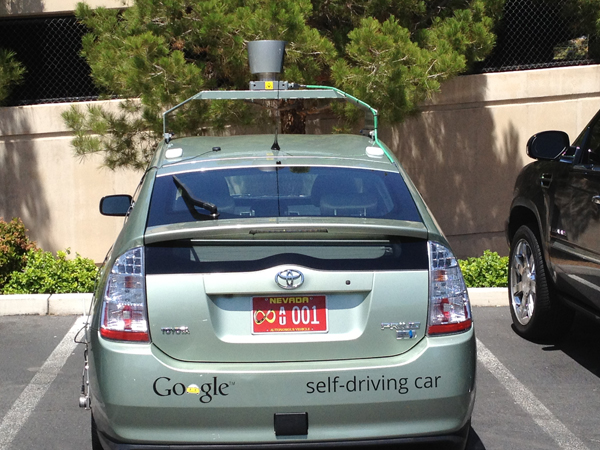

In [72]:
file_path = image_path[80] 
img = cv2.imread(file_path)
img = io.imread(file_path) 
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=1804, x1=2493, y0=1734, y1=1882, xref='x', yref='y',line_color='cyan')


In [73]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Preprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [74]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [75]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

In [76]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model = Model(inputs=inception_resnet.input,outputs=headmodel)

In [77]:
model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 111, 111, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_20

In [78]:
tfb = TensorBoard('object_detection')
history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test),callbacks=[tfb])

Epoch 1/50
35/35 [==============================] - 85s 2s/step - loss: 0.0334 - val_loss: 0.0220
Epoch 2/50
35/35 [==============================] - 130s 4s/step - loss: 0.0123 - val_loss: 0.0151
Epoch 3/50
35/35 [==============================] - 148s 4s/step - loss: 0.0062 - val_loss: 0.0163
Epoch 4/50
35/35 [==============================] - 128s 4s/step - loss: 0.0045 - val_loss: 0.0154
Epoch 5/50
35/35 [==============================] - 129s 4s/step - loss: 0.0045 - val_loss: 0.0132
Epoch 6/50
35/35 [==============================] - 121s 3s/step - loss: 0.0036 - val_loss: 0.0113
Epoch 7/50
35/35 [==============================] - 155s 4s/step - loss: 0.0036 - val_loss: 0.0125
Epoch 8/50
35/35 [==============================] - 134s 4s/step - loss: 0.0035 - val_loss: 0.0122
Epoch 9/50
35/35 [==============================] - 167s 5s/step - loss: 0.0027 - val_loss: 0.0155
Epoch 10/50
35/35 [==============================] - 180s 5s/step - loss: 0.0027 - val_loss: 0.0153
Epoch 11/5

In [98]:
model.save('./object_detection.h5')

In [99]:
model = tf.keras.models.load_model('./object_detection.h5')

1/1 [==============================] - 0s 148ms/step
(766, 648) (1237, 843)



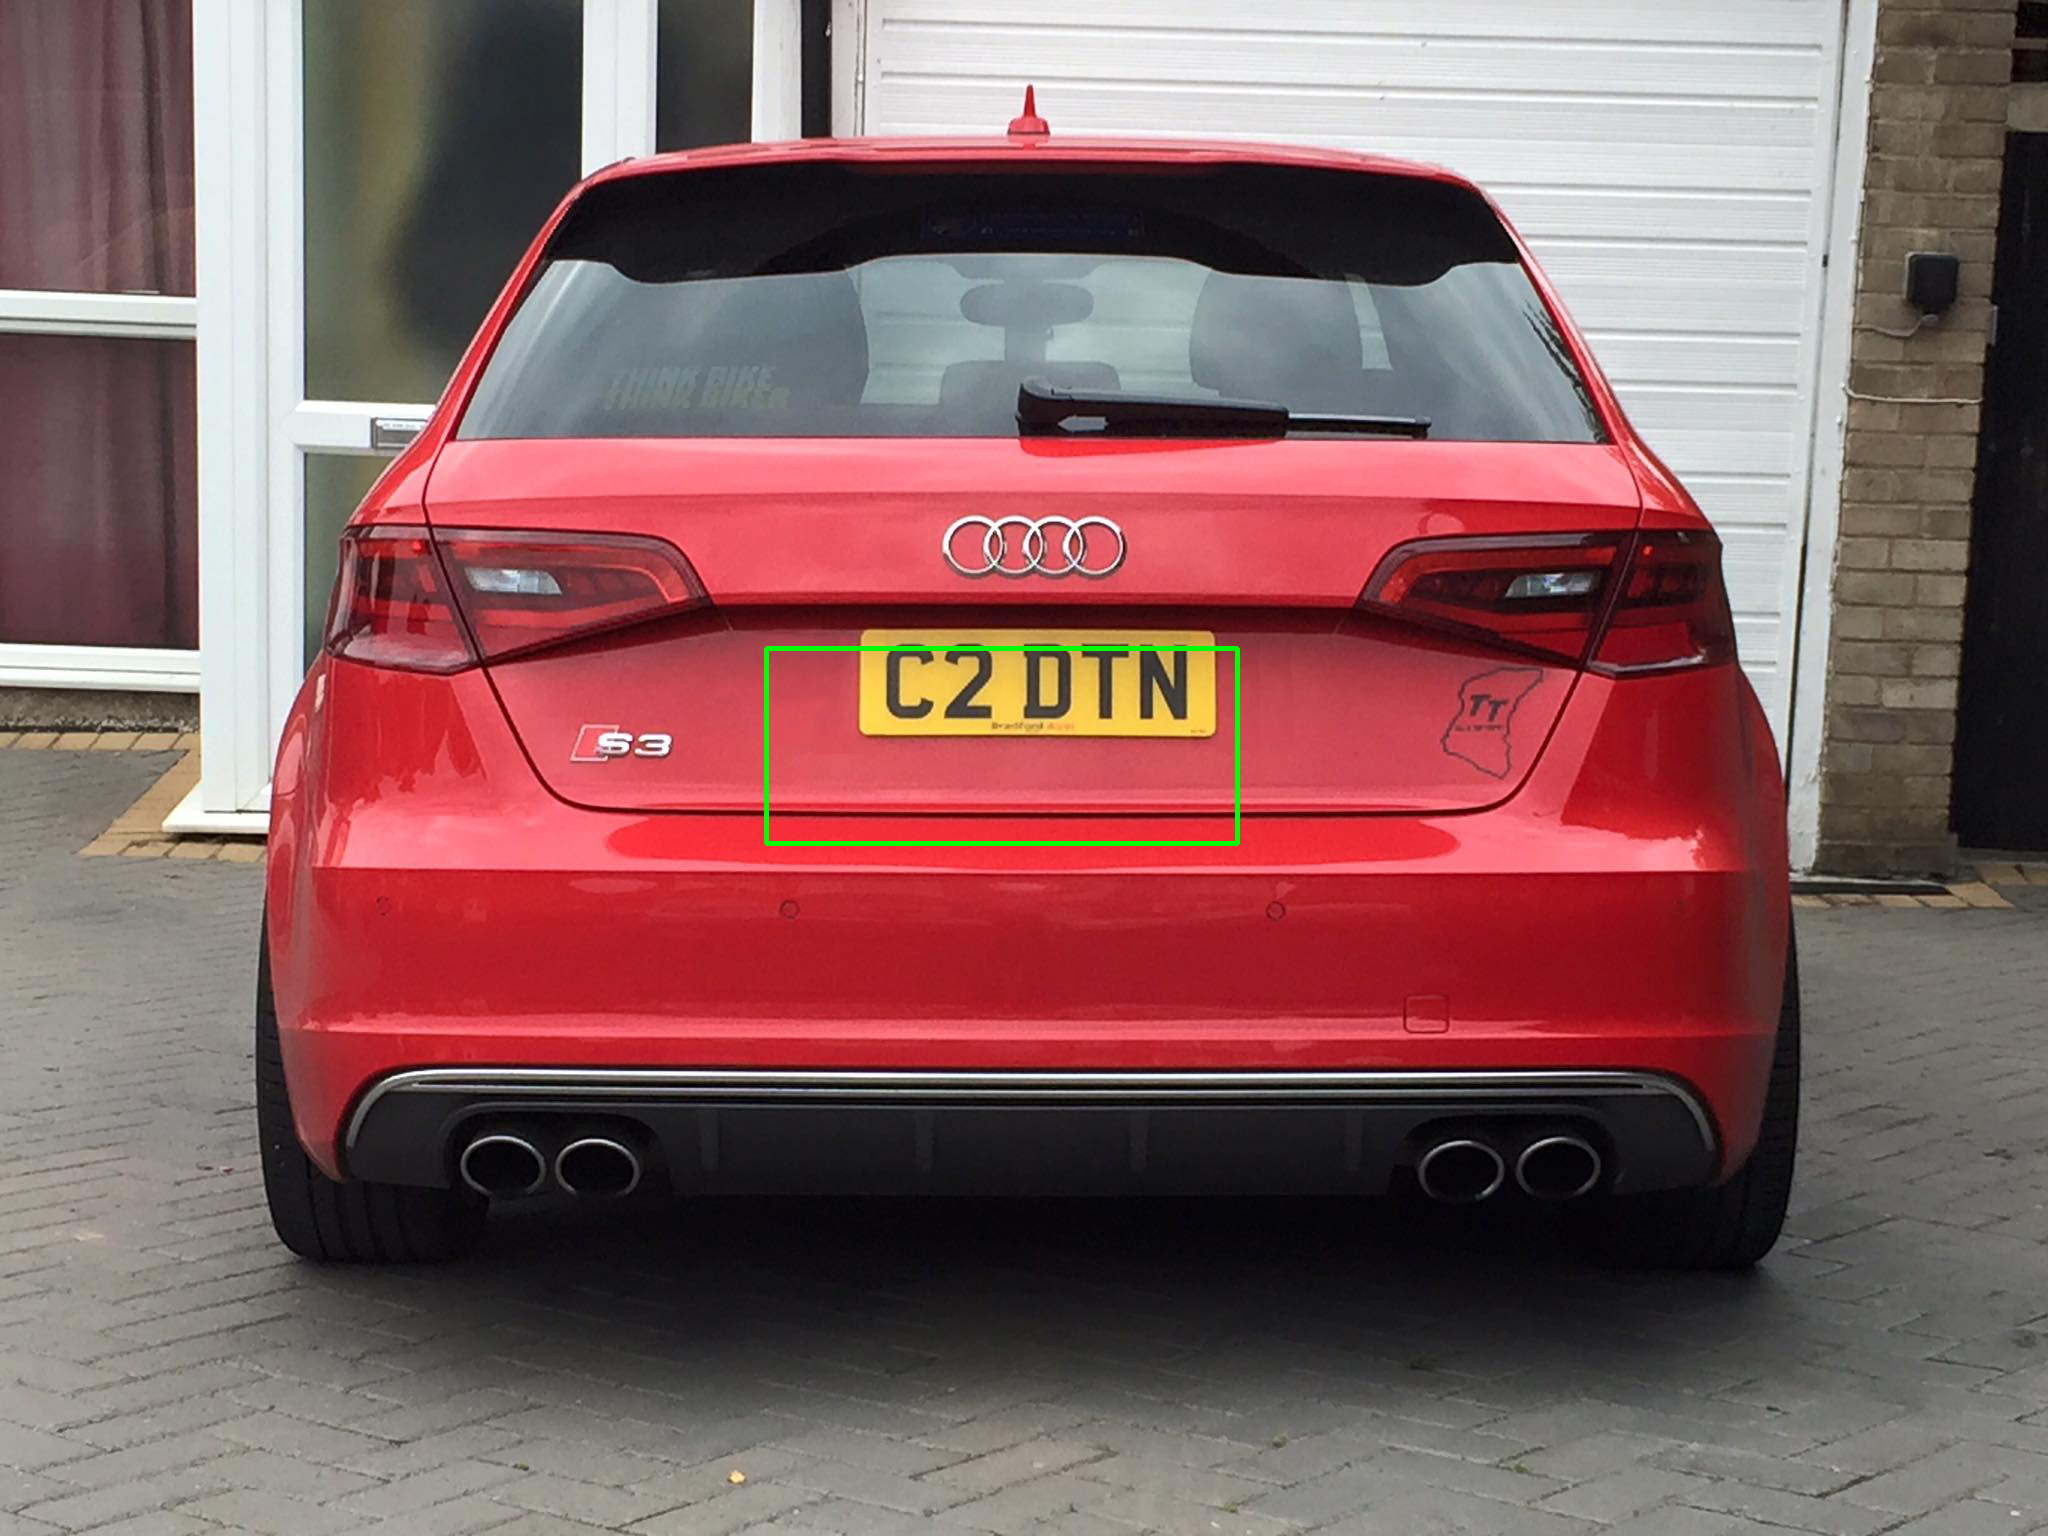

In [102]:
# Create pipeline
path = '/Users/nehal/cut.jpg'
def object_detection(path):
    
    # Read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
    image1 = load_img(path,target_size=(224,224))
    
    # Data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # Convert to array & normalized
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # Make predictions
    coords = model.predict(test_arr)
    
    # Denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # Draw bounding on top the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))


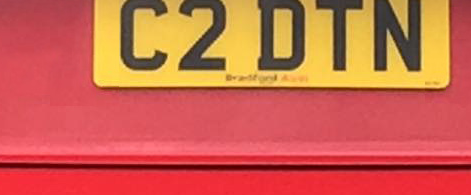

In [103]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10))